## Retargetable compilation with Qiskit

This notebook illustrates the retargetability of the Qiskit transpiler. In it, we work primarily with the Target object, which is a representation of the instruction set of the quantum computer along with the different properties (errors, durations, calibrations) characterized by each instruction.

Here we illustrate how changing the target makes the transpiler retarget its output to best utilize the available instruction set.

In [1]:
import math

from qiskit import transpile
from qiskit.transpiler.passes import *
from qiskit.transpiler import PassManager, CouplingMap, Target, InstructionProperties
from qiskit.circuit.library import *
from qiskit.circuit import Parameter
from qiskit.quantum_info import Operator, average_gate_fidelity

In [2]:
def synthesize_over_target(target):
    pm = PassManager([
        Collect2qBlocks(),
        ConsolidateBlocks(force_consolidate=True),
        UnitarySynthesis(target=target),
        Optimize1qGatesDecomposition(target)
    ])

    qv_t = pm.run(qv)
    
    print(average_gate_fidelity(Operator(qv), Operator(qv_t)))
    
    display(qv_t.draw('mpl', fold=-1))

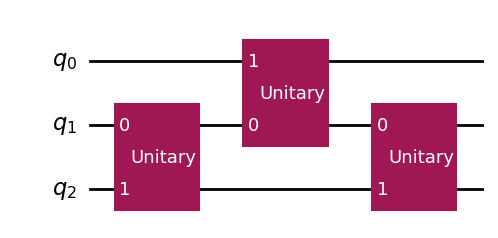

In [3]:
num_qubits = 3
qv = QuantumVolume(num_qubits, seed=4).decompose()
qv.draw('mpl', fold=-1)

In [4]:
# build Target
target = Target()

theta = Parameter('theta')
phi = Parameter('phi')   
lam = Parameter('lambda')

sx_props = {
    (0,): InstructionProperties(duration=2.88e-8, error=0.00038),
    (1,): InstructionProperties(duration=2.88e-8, error=0.00085),
    (2,): InstructionProperties(duration=2.88e-8, error=0.00093),
    (3,): InstructionProperties(duration=2.88e-8, error=0.00096),
    (4,): InstructionProperties(duration=2.88e-8, error=0.0012)
}

rz_props = {
    (0,): InstructionProperties(duration=0, error=0),
    (1,): InstructionProperties(duration=0, error=0),
    (2,): InstructionProperties(duration=0, error=0),
    (3,): InstructionProperties(duration=0, error=0),
    (4,): InstructionProperties(duration=0, error=0)
}

cx_props = {
    (0, 1): InstructionProperties(duration=1.74e-6, error=.005),
    (1, 2): InstructionProperties(duration=1.74e-6, error=.03),
    (2, 3): InstructionProperties(duration=1.74e-6, error=.02),
    (3, 4): InstructionProperties(duration=1.74e-6, error=.01)
}

target.add_instruction(RZGate(theta), rz_props)
target.add_instruction(SXGate(), sx_props)
target.add_instruction(CXGate(), cx_props, name='cx')

0.9999999999999996


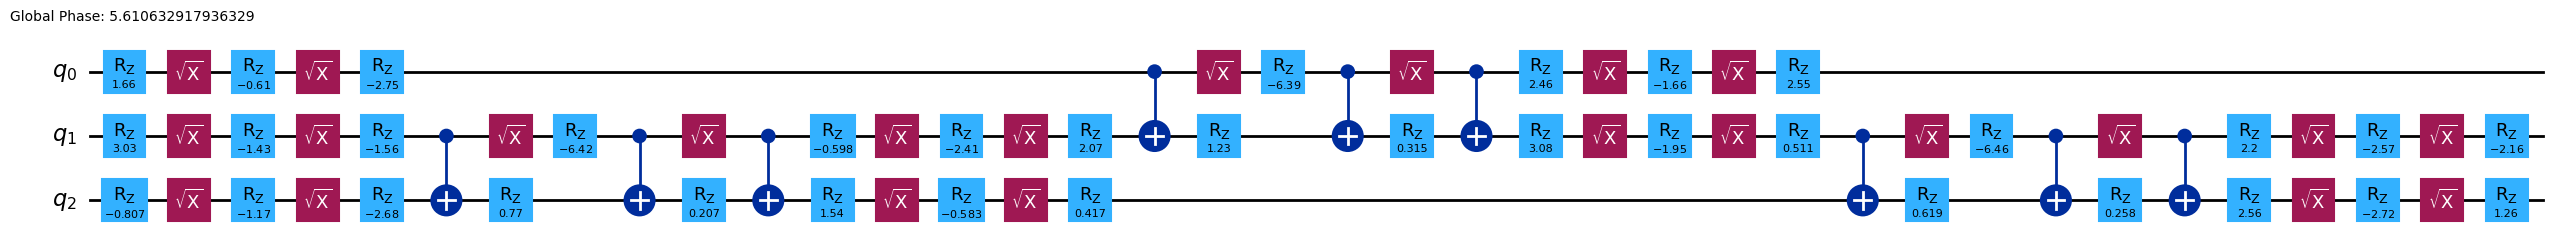

In [5]:
synthesize_over_target(target)

Now let's say I calibrate a continuous $RX(\theta)$ gate and a better controlled Hadamard.

In [6]:
# add to Target

rx_props = {
    (0,): InstructionProperties(duration=3.23e-8, error=0.00038),
    (1,): InstructionProperties(duration=3.23e-8, error=0.00085),
    (2,): InstructionProperties(duration=3.23e-8, error=0.00093),
    (3,): InstructionProperties(duration=3.23e-8, error=0.00096),
    (4,): InstructionProperties(duration=3.23e-8, error=0.0012)
}

ch_props = {
    (0, 1): InstructionProperties(duration=1.74e-6, error=.1),
    (1, 2): InstructionProperties(duration=1.74e-6, error=.7),
    (2, 3): InstructionProperties(duration=1.74e-6, error=.004),
    (3, 4): InstructionProperties(duration=1.74e-6, error=.005)
}

target.add_instruction(RXGate(theta), rx_props, name='rx')
target.add_instruction(CHGate(), ch_props, name='ch')

0.999999999999999


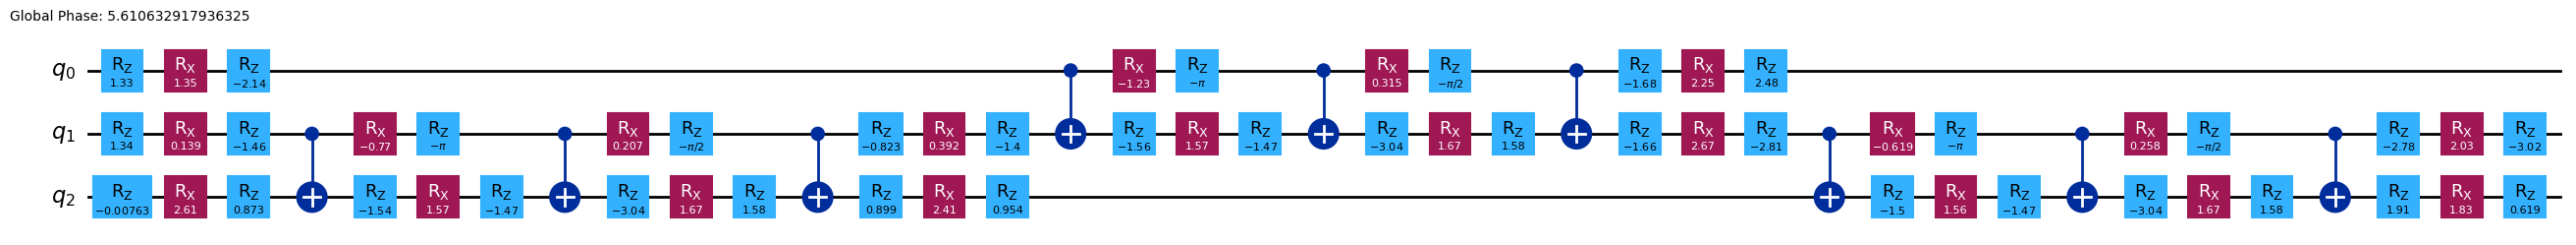

In [7]:
synthesize_over_target(target)

Now let's add some fractional controlled gates such as $RZZ(\theta_1), RZZ(\theta_2), ...$

In [8]:
# add more to the Target

u_props = {
    (0,): InstructionProperties(duration=3.23e-8, error=0.00008),
    (1,): InstructionProperties(duration=3.23e-8, error=0.004),
    (2,): InstructionProperties(duration=3.23e-8, error=0.003),
    (3,): InstructionProperties(duration=3.23e-8, error=0.00006),
    (4,): InstructionProperties(duration=3.23e-8, error=0.012)
}

rzz_18_props = {
    (0, 1): InstructionProperties(duration=0.74e-7, error=.003),
    (1, 2): InstructionProperties(duration=0.74e-7, error=.01),
    (2, 3): InstructionProperties(duration=0.74e-7, error=.001),
    (3, 4): InstructionProperties(duration=0.74e-7, error=.001)
}

rzz_45_props = {
    (0, 1): InstructionProperties(duration=1.04e-6, error=.01),
    (1, 2): InstructionProperties(duration=1.04e-6, error=.02),
    (2, 3): InstructionProperties(duration=1.04e-6, error=.002),
    (3, 4): InstructionProperties(duration=1.04e-6, error=.002)
}

target.add_instruction(UGate(theta, phi, lam), u_props, name='u')
target.add_instruction(RZZGate(math.pi / 10), rzz_18_props, name='rzz_18')
target.add_instruction(RZZGate(math.pi / 4), rzz_45_props, name='rzz_45')

0.9998842883784064


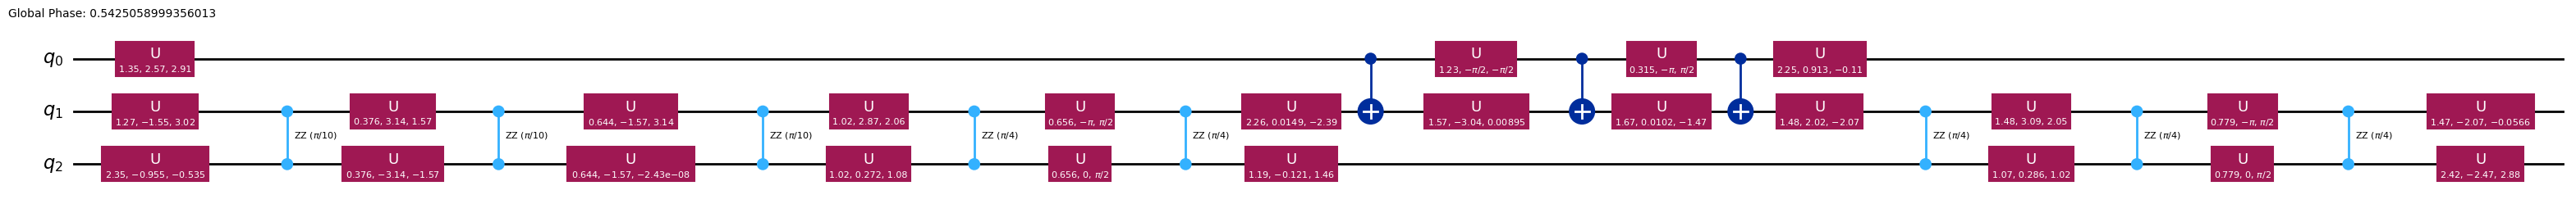

In [9]:
synthesize_over_target(target)

This extends further. For example a trapped-ion quantum computer runs XX gates and R gates.

In [10]:
# build new Target for RXX + R machine (e.g. trapped ion)
target = Target()

r_props = {
    (0,): InstructionProperties(duration=3.23e-8, error=0.00038),
    (1,): InstructionProperties(duration=3.23e-8, error=0.00085),
    (2,): InstructionProperties(duration=3.23e-8, error=0.00093),
    (3,): InstructionProperties(duration=3.23e-8, error=0.00096),
    (4,): InstructionProperties(duration=3.23e-8, error=0.0012)
}

rxx_90_props = {
    (0, 1): InstructionProperties(duration=1.74e-6, error=.001),
    (1, 2): InstructionProperties(duration=1.74e-6, error=.003),
    (2, 3): InstructionProperties(duration=1.74e-6, error=.004),
    (3, 4): InstructionProperties(duration=1.74e-6, error=.005)
}

rxx_45_props = {
    (0, 1): InstructionProperties(duration=1.74e-6, error=.001),
    (1, 2): InstructionProperties(duration=1.74e-6, error=.002),
    (2, 3): InstructionProperties(duration=1.74e-6, error=.002),
    (3, 4): InstructionProperties(duration=1.74e-6, error=.003)
}

target.add_instruction(RGate(theta, phi), r_props, name='r')
target.add_instruction(RXXGate(math.pi / 2), rxx_90_props, name='rxx_90')
target.add_instruction(RXXGate(math.pi / 4), rxx_45_props, name='rxx_45')

0.9999999999999996


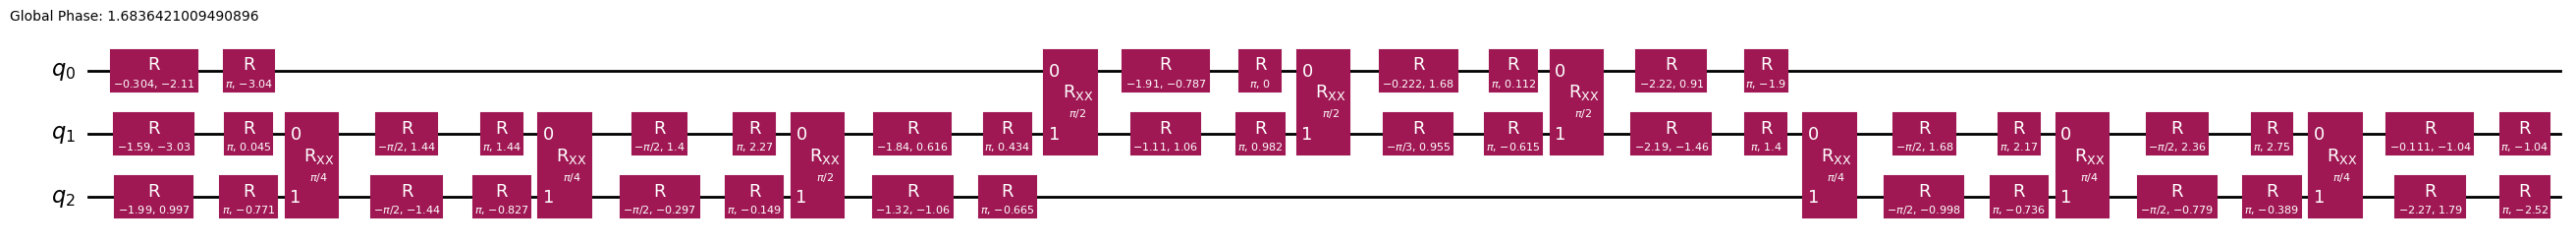

In [11]:
synthesize_over_target(target)

### Which basis gates are supported?

**1-qubit gates:**
- Continuous rotations around 2 orthogonal Pauli basis (red lines in the left figure). That is RX, RY or RZ.

- A discrete $\pi/2$ rotation paired with a continuous orthogonal rotation. That is SX, SY, S.

- A discrete $\pi$ rotation paired with a continous orthogonal rotation (only special cases). That is X, Y, Z.

**2-qubit gates:**
- A single "supercontrolled" basis (green line). Examples are CZGate, CXGate, CHGate, BGate, iSWAPGate, DCXGate, etc.

- Multiple "controlled" basis (red line). This case is solved optimally according to their cost. Examples are RXX(pi/2), RZZ(pi/6), RYY(pi/13), etc. etc.

- Sqrt(iSWAP). This case is also solved optimally.